In [1]:
import time

import numpy as np
import pandas as pd
import datetime as dt
import xgboost as xgb

from itertools import combinations

from sklearn import metrics
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

In [2]:
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

In [3]:
df_train = pd.read_csv("../data/train_new.csv")
df_test = pd.read_csv("../data/test_new.csv")

In [4]:
test_id = df_test.id.values

In [5]:
features = list(set(df_train.columns.tolist()) - set(['formation_energy_ev_natom',
                                                'bandgap_energy_ev', 
                                                'id',
                                                'lattice_angle_alpha_degree_r',
                                                'lattice_angle_beta_degree_r',
                                                'lattice_angle_alpha_degree_r']))
targets = ['formation_energy_ev_natom', 'bandgap_energy_ev']

y_e = np.sqrt(df_train['formation_energy_ev_natom'].values +0.5)
y_be = np.sqrt(df_train['bandgap_energy_ev'].values +0.5)

y_e_l = np.log(df_train['formation_energy_ev_natom'].values +1)
y_be_l = np.log(df_train['bandgap_energy_ev'].values +1)

y_e_l_max = y_e_l.max()
y_be_l_max = y_be_l.max()

y_e_max = y_e.max()
y_be_max = y_be.max()

dist_features = [x for x in df_train.columns.tolist() if x.startswith('dist')]
path_features = [x for x in df_train.columns.tolist() if x.startswith('path')]
angle_features = [x for x in df_train.columns.tolist() if x.startswith('angle')]
dihedral_features = [x for x in df_train.columns.tolist() if x.startswith('dihedral')]
percent_features = [x for x in df_train.columns.tolist() if x.startswith('percent')]
avg_features = [x for x in df_train.columns.tolist() if x.startswith('avg')]
lattice_angle_features = [x for x in df_train.columns.tolist() if x.startswith('lattice_angle')]
features_be = ['lattice_vector_1_ang','lattice_vector_2_ang','lattice_vector_3_ang']

## DBSCAN

In [6]:
features_be = ['lattice_vector_1_ang',
               'lattice_vector_2_ang',
               'lattice_vector_3_ang']
X_be = df_train[features_be]
X_test_be = df_test[features_be]
frames = [X_be, X_test_be]
result = pd.concat(frames)

result_s = StandardScaler().fit_transform(result)
db = DBSCAN(eps=0.14, min_samples=10).fit(result_s)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels_both = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_both)) - (1 if -1 in labels_both else 0)
labels_both = db.labels_
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(result, labels_both))

# Define the the cluster of every sample
train_labels = labels_both[:2400]
test_labels = labels_both[2400:]

Estimated number of clusters: 11
Silhouette Coefficient: 0.674


## Initialize submition file

In [7]:
sub = pd.DataFrame()
sub['id'] = test_id

## Predict formation energy

In [17]:
# feat_list = ['lattice_angle_alpha_degree',
#              'lattice_angle_gamma_degree',
#              'number_of_total_atoms',
#              'vol']+avg_features+features_be+percent_features+dist_features

feat_list=['lattice_angle_alpha_degree',
           'lattice_angle_gamma_degree',
           'lattice_angle_gamma_degree',
           'vol',
           'atomic_density',
           'lattice_vector_1_ang',
           'lattice_vector_2_ang',
           'lattice_vector_3_ang']+avg_features+percent_features+dist_features



sub['formation_energy_ev_natom'] = np.zeros_like(test_id)

t = time.time()

kfold = 3
sscv = KFold(n_splits=kfold, shuffle=False, random_state=41)



for cluster in range(11):
    print('--------------------------------------')
    print('cluster: '+str(cluster))
    print('--------------------------------------')
    
    
    
    X_test_e  = df_test[feat_list].values
    X_train_e = df_train[feat_list].values
    
    X_test = X_test_e[test_labels==cluster]
    X = X_train_e[train_labels==cluster]
    
    y = np.log(df_train['formation_energy_ev_natom'].values +1)[train_labels==cluster]
    
    for i, (train_index, test_index) in enumerate(sscv.split(X, y)):
        
        print('[Fold %d/%d]' % (i + 1, kfold))
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        
        #Instantiate a Model
        regr = linear_model.LinearRegression()
        
        # Train the model using the training sets
        regr.fit(X_train, y_train)
        
        # Predict on our test data
        y_predicted = regr.predict(X_valid)
        score = rmsle(y_predicted, y_valid)
        print('[Fold {}/{} validation score: {}]'.format(i + 1, kfold, score))
        
        # Make predictions using the testing set
        y_test = regr.predict(X_test)
        test_ids = test_id[test_labels==cluster]
        sub.loc[sub['id'].isin(test_ids),'formation_energy_ev_natom'] += (np.exp(y_test)-1)/kfold #(np.exp(y_test)-1)/kfold #((((y_test)**2)-0.5)/kfold)

    
print()
print('this took {}seconds'.format(time.time()-t))

--------------------------------------
cluster: 0
--------------------------------------
[Fold 1/3]
[Fold 1/3 validation score: 0.01850772732081662]
[Fold 2/3]
[Fold 2/3 validation score: 0.018736249304929828]
[Fold 3/3]
[Fold 3/3 validation score: 0.019709769094983398]
--------------------------------------
cluster: 1
--------------------------------------
[Fold 1/3]
[Fold 1/3 validation score: 0.04190468671831124]
[Fold 2/3]
[Fold 2/3 validation score: 0.04051530097921081]
[Fold 3/3]
[Fold 3/3 validation score: 0.040932856805868764]
--------------------------------------
cluster: 2
--------------------------------------
[Fold 1/3]
[Fold 1/3 validation score: 0.03690336670345506]
[Fold 2/3]
[Fold 2/3 validation score: 0.0371860380089041]
[Fold 3/3]
[Fold 3/3 validation score: 0.03568850926174453]
--------------------------------------
cluster: 3
--------------------------------------
[Fold 1/3]
[Fold 1/3 validation score: 0.016640470191478903]
[Fold 2/3]
[Fold 2/3 validation score: 0.

/home/laith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


## Predict bandgap energy

In [19]:
# feat_list = ['lattice_angle_alpha_degree',
#              'lattice_angle_gamma_degree',
#              'number_of_total_atoms',
#              'vol']+avg_features+features_be+percent_features+dist_features

feat_list = ['lattice_angle_alpha_degree',
               'lattice_angle_gamma_degree',
               'lattice_angle_gamma_degree',
               'number_of_total_atoms',
               'vol',
               'atomic_density',
               'lattice_vector_1_ang',
               'lattice_vector_2_ang',
               'lattice_vector_3_ang']+avg_features+percent_features+dist_features+angle_features+dihedral_features

sub['bandgap_energy_ev'] = np.zeros_like(test_id)

t = time.time()

kfold = 12
sscv = KFold(n_splits=kfold, shuffle=False, random_state=41)



for cluster in range(11):
    print('--------------------------------------')
    print('cluster: '+str(cluster))
    print('--------------------------------------')
    

    X_test_be = df_test[feat_list].values

    X_train_be = df_train[feat_list].values
    
    X = X_train_be[train_labels==cluster]
    
    y = np.log(df_train['bandgap_energy_ev'].values +1)[train_labels==cluster]
    
    X_test = X_test_be[test_labels==cluster]
    
    for i, (train_index, test_index) in enumerate(sscv.split(X, y)):
        print('[Fold %d/%d]' % (i + 1, kfold))
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        
        regr = linear_model.ElasticNetCV(max_iter=10000)
        # Train the model using the training sets
        regr.fit(X_train, y_train)
        
        
        # Predict on our test data
        y_predicted = regr.predict(X_valid)
        score = rmsle(y_predicted, y_valid)
        print('[Fold {}/{} validation score: {}]'.format(i + 1, kfold, score))
        
        # Make predictions using the testing set
        y_test = regr.predict(X_test)

        test_ids = test_id[test_labels==cluster]
        sub.loc[sub['id'].isin(test_ids),'bandgap_energy_ev'] += ((np.exp(y_test)-1)/kfold

    
print()
print('this took {}seconds'.format(time.time()-t))

--------------------------------------
cluster: 0
--------------------------------------
[Fold 1/12]
[Fold 1/12 validation score: 0.00865015026920549]
[Fold 2/12]
[Fold 2/12 validation score: 0.007803671763120974]
[Fold 3/12]
[Fold 3/12 validation score: 0.008559445879399823]
[Fold 4/12]
[Fold 4/12 validation score: 0.010442196424751063]
[Fold 5/12]
[Fold 5/12 validation score: 0.011049909450069489]
[Fold 6/12]
[Fold 6/12 validation score: 0.012668922437620186]
[Fold 7/12]
[Fold 7/12 validation score: 0.014117730457577308]
[Fold 8/12]
[Fold 8/12 validation score: 0.008990454529729809]
[Fold 9/12]
[Fold 9/12 validation score: 0.015214107199209582]
[Fold 10/12]
[Fold 10/12 validation score: 0.009467434192990395]
[Fold 11/12]
[Fold 11/12 validation score: 0.010551729907026505]
[Fold 12/12]
[Fold 12/12 validation score: 0.008967271872178115]
--------------------------------------
cluster: 1
--------------------------------------
[Fold 1/12]
[Fold 1/12 validation score: 0.0467324823705434]


[Fold 9/12 validation score: 0.10270226309930554]
[Fold 10/12]
[Fold 10/12 validation score: 0.06175901907029687]
[Fold 11/12]
[Fold 11/12 validation score: 0.04722763884855834]
[Fold 12/12]
[Fold 12/12 validation score: 0.0797368884506328]
--------------------------------------
cluster: 10
--------------------------------------
[Fold 1/12]
[Fold 1/12 validation score: 0.025364065893898592]
[Fold 2/12]
[Fold 2/12 validation score: 0.011521783480266445]
[Fold 3/12]
[Fold 3/12 validation score: 0.048968709464827676]
[Fold 4/12]
[Fold 4/12 validation score: 0.022007382222587912]
[Fold 5/12]
[Fold 5/12 validation score: 0.023074317772817987]
[Fold 6/12]
[Fold 6/12 validation score: 0.0006596358322548124]
[Fold 7/12]
[Fold 7/12 validation score: 0.01301483042961249]
[Fold 8/12]
[Fold 8/12 validation score: 0.2459950059062097]
[Fold 9/12]
[Fold 9/12 validation score: 0.04523114256669947]
[Fold 10/12]
[Fold 10/12 validation score: 0.033718118901848726]
[Fold 11/12]
[Fold 11/12 validation scor

In [12]:
sample_df = pd.read_csv('../output/sample.csv')



In [13]:
subs = sample_df[sample_df['id']==94]['formation_energy_ev_natom'].values[0]
sub.loc[sub.formation_energy_ev_natom<0,'formation_energy_ev_natom']= subs

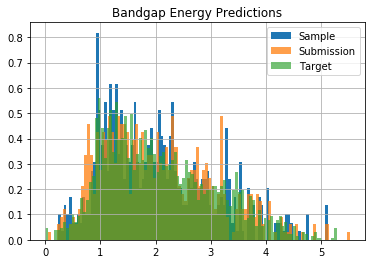

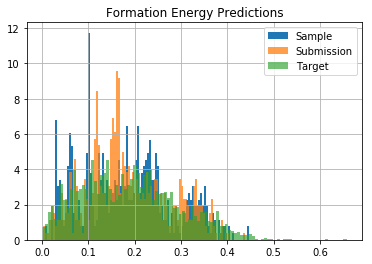

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_df.bandgap_energy_ev.hist(label='Sample', alpha=1,bins=100, normed=True)
sub.bandgap_energy_ev.hist(label='Submission', alpha=0.75,bins=100, normed=True)
df_train['bandgap_energy_ev'].hist(label='Target', alpha=0.65,bins=100, normed=True)
plt.title('Bandgap Energy Predictions')
plt.legend()
plt.show()

sample_df.formation_energy_ev_natom.hist(label='Sample', alpha=1,bins=100, normed=True)
sub.formation_energy_ev_natom.hist(label='Submission', alpha=0.75,bins=100, normed=True)
df_train['formation_energy_ev_natom'].hist(label='Target', alpha=0.65,bins=100, normed=True)
plt.title('Formation Energy Predictions')
plt.legend()
plt.show()


In [15]:
sub.id = sub.id.astype('Int32')
sub.to_csv('../output/dlp.csv', index=False)